In [1]:
""" Import packages """
import os
from datetime import datetime
import pickle
import sys
import logging
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, '../scripts/')

logging.basicConfig(filename='../logs/modeling.log', filemode='a',
                    encoding='utf-8', level=logging.DEBUG)

warnings.filterwarnings("ignore")

In [2]:
from modeling import build_train_test_datasets
from modeling import build_sequences
from modeling import train_lstm

2023-09-21 15:01:54.456538: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 15:01:55.976801: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from explorer import DataTransformer

transformer = DataTransformer()

In [4]:
REPO = "../"
filepath = "data/cleaned/study_dataset.csv"
rev = "Cleaneddatav22mf"

### Importing the data

In [5]:
data = transformer.load_data(ext="csv", filepath=filepath, repo=REPO, rev=rev, header=0, parse_dates=["Date"])
data.head()

,ISO3,Date,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7,Feature_1,...,Feature_14,Feature_17,Feature_19,Feature_22,Feature_24,Feature_27,Feature_31,Feature_32,Feature_33,Feature_34
0,BFA,2000-12-31,603.210999,235.128065,874.845987,25.571181,62.627879,450.176799,717.149334,2.55,...,0.098126,856.4,26.376096,178.7,2.983886,85.40,6.857565,0,0,0
1,BFA,2001-12-31,601.937744,256.009859,918.916428,27.686540,66.619251,469.845175,876.388458,2.97,...,0.087891,967.8,26.193348,174.7,3.040729,85.49,6.867020,0,0,0
2,BFA,2002-12-31,595.852051,260.730606,958.846796,29.485652,72.230232,505.134949,743.621255,2.90,...,0.083175,942.7,26.010599,170.2,3.074790,85.43,6.874386,0,0,0
3,BFA,2003-12-31,585.123291,271.081041,965.412955,29.644367,72.615529,508.274478,881.413820,2.60,...,0.081205,996.3,25.827851,165.0,3.104518,85.30,6.865103,0,0,0
4,BFA,2004-12-31,562.411316,264.250419,925.186169,27.621911,71.165711,498.971133,873.945620,3.00,...,0.077845,940.7,25.645102,159.1,3.138021,85.31,6.873132,0,0,0


### Build Train and Test Dataset: include preprocessing

In [6]:
index_cols = ["ISO3", "Date"]
target_columns = [col for col in data.columns if col.startswith("Target")]
input_columns = [col for col in data.columns if col.startswith("Feature")] + target_columns
feature_columns = [col for col in data.columns if col.startswith("Feature")]

In [7]:
d_train_test, scaler_inputs, scaler_targets = build_train_test_datasets(
    data,
    index_cols=index_cols,
    input_cols=input_columns,
    target_cols=target_columns,
    train_limit="2019",
    scaler_str="standard"
)

In [8]:
X_train = d_train_test["Scaled"]["train"]["Inputs"]
y_train = d_train_test["Scaled"]["train"]["Targets"]
X_test = d_train_test["Scaled"]["test"]["Inputs"]
y_test = d_train_test["Scaled"]["test"]["Targets"]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(95, 27) (95, 7) (20, 27) (20, 7)


### Build sequences

In [9]:
seq_length = 2

In [10]:
X_train, y_train = build_sequences(X_train, y_train, seq_length=seq_length, index_cols=index_cols)

In [11]:
X_test, y_test = build_sequences(X_test, y_test, seq_length=seq_length, index_cols=index_cols)

In [12]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) 

(85, 2, 27) (85, 7) (10, 2, 27) (10, 7)


### Train model

In [13]:
# Learning parameters
d_learning_params = {}
d_learning_params['batch_size'] = 3
d_learning_params['epochs'] = 100
d_learning_params['activation_fn'] = "tanh"
d_learning_params['loss_fn'] = "mse"
d_learning_params['metrics'] = ['mae']
d_learning_params['optimizer'] = "adam"
d_learning_params['scalers'] = [scaler_inputs, scaler_targets]
d_learning_params['feat_names'] = input_columns
d_learning_params['target_names'] = target_columns
d_learning_params['d_train_test'] = d_train_test
d_learning_params['seq_train_test_val'] = {
    "train": {"features": X_train, "targets": y_train },
    "test": {"features": X_test, "targets": y_test}
}
d_learning_params['layers'] = [64, 32, 24]


2023-09-21 15:02:00.985938: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 64)             23552     
                                                                 
 dropout (Dropout)           (None, 2, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 2, 32)             12416     
                                                                 
 dropout_1 (Dropout)         (None, 2, 32)             0         
                                                                 
 lstm_2 (LSTM)               (None, 24)                5472      
                                                                 
 dropout_2 (Dropout)         (None, 24)                0         
                                                                 
 dense (Dense)               (None, 7)                 1

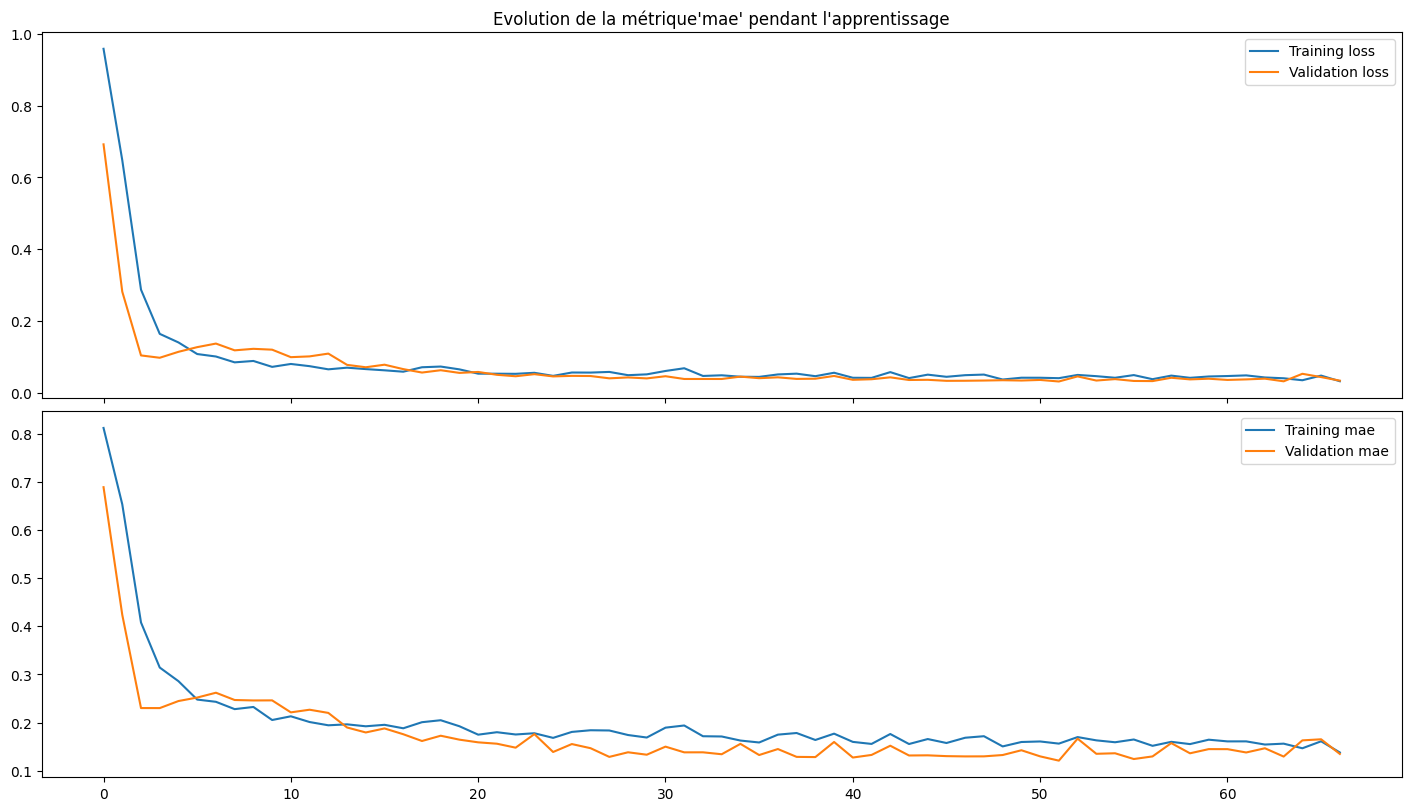

In [14]:
# Get today datetime to create the model file
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = os.path.join("../models", "LSTM_MBIOST", "Time_lag_{}".format(seq_length), current_datetime)
params_file = os.path.join(results_dir, "lstm_params_{}.pkl".format(str(current_datetime)))

# Create results directory if not exists
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Save learning parameters
with open(params_file, 'wb') as fp:
    pickle.dump(d_learning_params, fp)

model_lstm, scores = train_lstm(X_train, y_train, X_test, y_test, d_learning_params, results_dir)

# Save model scores
d_scores = d_learning_params.copy()
d_scores["scores"] = scores
scores_file = os.path.join(results_dir, "lstm_scores_{}.pkl".format(str(current_datetime)))

print("Model performances")
print("\t --> R2 Score (The model is perfect with a score of 1)")
print("\t \t --> Train set : {}".format(scores['R2']['train']))
print("\t \t --> Test set : {}".format(scores['R2']['test']))
print("\n")
print("\t --> MAE (Mean Absolute Error)")
print("\t \t --> Train set : {}".format(scores['MAE']['train']))
print("\t \t --> Test set : {}".format(scores['MAE']['test']))

# Save learning scores
with open(scores_file, 'wb') as fp:
    pickle.dump(d_scores, fp)

In [15]:
scores_file
# '../models/LSTM_MBIOST/Time_lag_2/20230921_144602/lstm_scores_20230921_144602.pkl': 0.881
# '../models/LSTM_MBIOST/Time_lag_2/20230921_150200/lstm_scores_20230921_150200.pkl': 0.892

'../models/LSTM_MBIOST/Time_lag_2/20230921_150200/lstm_scores_20230921_150200.pkl'

In [16]:
with open(scores_file, 'rb') as f:
    x = pickle.load(f)

In [17]:
x["scores"]

{'R2': {'train': 0.987, 'test': 0.892}, 'MAE': {'train': 0.086, 'test': 0.135}}